In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from skorch import NeuralNetClassifier
from skorch.callbacks import Checkpoint

sys.path.append("..")
from tfbs_check.modules import LSTMModule as torch_module
from tfbs_check.dataset import TFBSDataset
from tfbs_check.helper import Helper

import seqlogo

In [2]:
helper_class = Helper()
helper_class.add_variable("model", "../tfbs_check/results/model.pt")
helper_class.add_variable("binary", False)
helper_class.add_variable("hidden_size", 32)

True

In [3]:
helper_class.add_variable("promoters", "../../{0}".format(Helper.PROMOTER_FILE))
helper_class.add_variable("non-promoters", "../../{0}".format(Helper.NONPROMOTER_FILE))
promoter_path = os.path.abspath(helper_class.get_variable("promoters"))
nonpromoter_path = os.path.abspath(helper_class.get_variable("non-promoters"))

ds = TFBSDataset(file=promoter_path, neg_file=nonpromoter_path, binary=False, save_df=False)
helper_class.add_variable("length", ds.seqs_length)

True

In [4]:
fullpath = os.path.abspath(helper_class.get_variable("model"))
model_folder = os.path.dirname(fullpath)
cp = Checkpoint(dirname=model_folder, f_params=os.path.basename(fullpath))
# Binary(sigmoid): Use NeuralNetBinaryClassifier, num_classes=1, criterion=BCEWithLogitsLoss, binary=True
# Multi(softmax): Use NeuralNetClassifier, num_classes=2, criterion=CrossEntropyLoss, binary=False
    
net = NeuralNetClassifier(module=torch_module,
                          module__num_classes=1 if helper_class.get_variable("binary") else 2,
                          module__seqs_length=helper_class.get_variable("length"),
                          module__hidden_size=helper_class.get_variable("hidden_size"))
net.initialize()
print("Network Initialized")
net.load_params(checkpoint=cp)
print("Model Loaded")

Network Initialized
Model Loaded


In [5]:
print("Detaching weights from network")
output_weights = net.module_.out.weight.detach().numpy().astype(float)
promoter_weights = output_weights[helper_class.get_LABEL_dict()['Promoter']].reshape(helper_class.get_variable("length"), len(helper_class.get_DNA_dict()))
non_promoter_weights = output_weights[helper_class.get_LABEL_dict()['Non-Promoter']].reshape(helper_class.get_variable("length"), len(helper_class.get_DNA_dict()))
if (len(promoter_weights) != len(non_promoter_weights)):
    raise Exception("Something is wrong with the weights")

#position_weights = net.module_.help.weight.detach().numpy().astype(float)

Detaching weights from network


Analyzing promoter weights


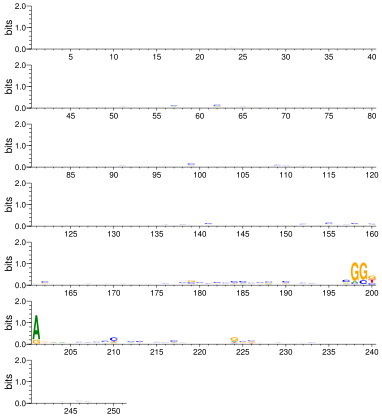

In [6]:
print("Analyzing promoter weights")
weights = Helper.softmax(promoter_weights.T)
ppm = weights.T
ppm_logo = seqlogo.Ppm(Helper.sum_one(ppm))
display(seqlogo.seqlogo(ppm_logo, ic_scale = True, format = 'svg', size = 'xxxlarge'))

Analyzing reciprocal filter weights


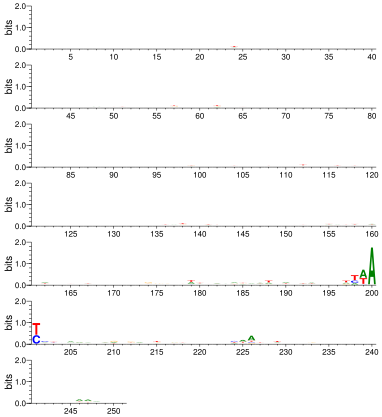

In [7]:
print("Analyzing reciprocal filter weights")

weights = Helper.softmax(promoter_weights.T)
ppm = Helper.reciprocal(weights).T
ppm_logo = seqlogo.Ppm(Helper.sum_one(ppm))
display(seqlogo.seqlogo(ppm_logo, ic_scale = True, format = 'svg', size = 'xxxlarge'))

Analyzing non-promoter weights


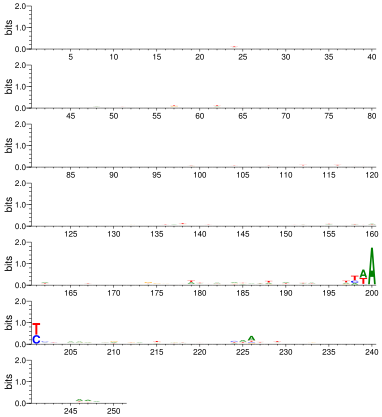

In [8]:
print("Analyzing non-promoter weights")
weights = Helper.softmax(non_promoter_weights.T)
ppm = weights.T
ppm_logo = seqlogo.Ppm(Helper.sum_one(ppm))
display(seqlogo.seqlogo(ppm_logo, ic_scale = True, format = 'svg', size = 'xxxlarge'))

In [9]:
# Example of custom seqlogo
#ppm_logo = seqlogo.Ppm(Helper.sum_one(ppm), alphabet_type='custom', alphabet='ACGT', background=[0.25,0.25,0.25,0.25])
#display(seqlogo.seqlogo(ppm_logo, ic_scale = True, format = 'svg', size = 'xxxlarge', color_scheme='classic'))